## Test the spearman loss funciton

this code is used to add spearman loss and weighted spearman loss into a torch.nn.Module 

In [8]:
import torch
print(torch.cuda.is_available())
import torchsort
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm

True


In [20]:
class SpearmanLoss(nn.Module):
    """
        Spearman Loss
    """

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    
    def forward(self, pred: torch.tensor, target: torch.tensor, **kw) -> torch.tensor:
        """
            pred: (B, 1)
            target: (B, 1)
        """
        pred = torchsort.soft_rank(pred, **kw)
        target = torchsort.soft_rank(target, **kw)
        pred = pred - pred.mean()
        pred = pred / pred.norm()
        target = target - target.mean()
        target = target / target.norm()
        return -(pred * target).sum()

In [27]:
class WeightedSpearmanLoss(nn.Module):
    """
        Spearman Loss
    """

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    
    def forward(self, pred: torch.tensor, target: torch.tensor, target_sort: torch.tensor, k=2, s=5, **kw) -> torch.tensor:
        
        pred_rank = torchsort.soft_rank(pred, **kw)
        target_rank = torchsort.soft_rank(target, **kw)
        
        target_sort = target_sort.flatten()
        W = torch.sqrt( (target_sort[pred_rank.flatten().long()-1] - target_sort[target_rank.flatten().long()-1]) ** 2 ).requires_grad_(False)
        # w = torch.tensor([0,0,0,0,19])
        pred_rank = pred_rank - pred_rank.mean()
        pred_rank = pred_rank / pred_rank.norm()
        target_rank = target_rank - target_rank.mean()
        target_rank = target_rank / target_rank.norm()
        
        W = 1/(1 + torch.exp(-k*(W-s)))
        W = W / W.sum()*len(W)
        return -(pred_rank * target_rank * W).sum()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 469.91it/s]

average loss=-0.9810812835395336


Text(0.5, 1.0, 'Spearman Loss, pred vs age, 10 health levels')

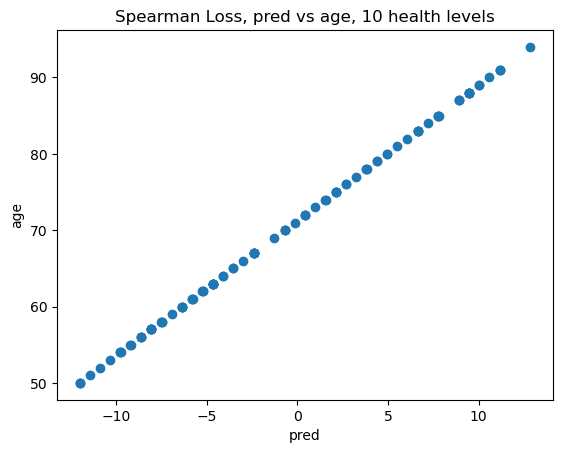

In [36]:
data_width = 100
sigma = 5

health_level = torch.randint(0, 10, (1,data_width)).float()
age = health_level * 4 + 55 + torch.randint(-sigma, sigma, (1,data_width)).float()

pred = torch.randn(1,data_width)


max_epoch = 100
lr = 1
device = torch.device("cuda:0")
pred = pred.to(device)
age = age.to(device)
health_level = health_level.to(device)
pred.requires_grad = True

loss = SpearmanLoss()
loss = loss.to(device)
optimizer = torch.optim.Adam([pred], lr=lr)

epoch_loss = 0
for epoch in tqdm(range(max_epoch)):
    optimizer.zero_grad()
    loss_value = loss(pred, age)
    loss_value.backward()
    optimizer.step()
    # print(f"epoch={epoch}, loss={loss_value.item()}")
    epoch_loss += loss_value.item()
print(f"average loss={epoch_loss/max_epoch}")
plt.scatter(pred.cpu().detach().numpy(), age.cpu().detach().numpy())
plt.xlabel("pred")
plt.ylabel("age")
plt.title("Spearman Loss, pred vs age, 10 health levels")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 427.06it/s]

average loss=-1.6370808616280557


Text(0.5, 1.0, 'Weighted Spearman Loss, pred vs age, 10 health levels')

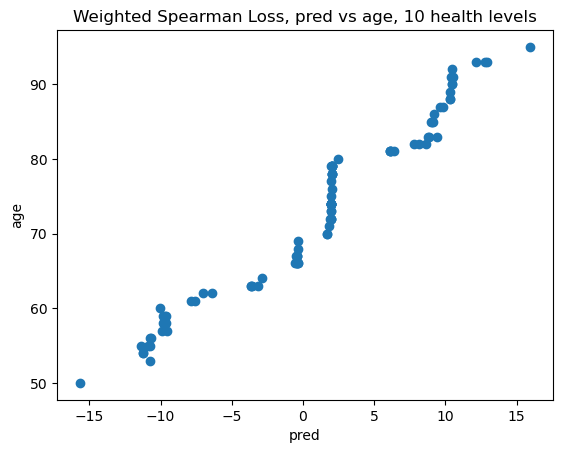

In [37]:
data_width = 100
sigma = 5

health_level = torch.randint(0, 10, (1,data_width)).float()
age = health_level * 4 + 55 + torch.randint(-sigma, sigma, (1,data_width)).float()

pred = torch.randn(1,data_width)


max_epoch = 100
lr = 1
device = torch.device("cuda:0")
pred = pred.to(device)
age = age.to(device)
age_sort = torch.sort(age, dim=1, descending=False)[0]
health_level = health_level.to(device)
pred.requires_grad = True

loss = WeightedSpearmanLoss()
loss = loss.to(device)
optimizer = torch.optim.Adam([pred], lr=lr)

epoch_loss = 0
for epoch in tqdm(range(max_epoch)):
    optimizer.zero_grad()
    loss_value = loss(pred, age, age_sort, k=2, s=5)
    loss_value.backward()
    optimizer.step()
    # print(f"epoch={epoch}, loss={loss_value.item()}")
    epoch_loss += loss_value.item()
print(f"average loss={epoch_loss/max_epoch}")
plt.scatter(pred.cpu().detach().numpy(), age.cpu().detach().numpy())
plt.xlabel("pred")
plt.ylabel("age")
plt.title("Weighted Spearman Loss, pred vs age, 10 health levels")